In [4]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [5]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [6]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(ismael_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [7]:
data_copy = king_all_copy
print(data_copy['date'])
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

0       1939-01-01
1       1939-01-02
2       1939-01-03
3       1939-01-04
4       1939-01-05
           ...    
24364   2020-12-25
24365   2020-12-26
24366   2020-12-27
24367   2020-12-28
24368   2020-12-29
Name: date, Length: 24369, dtype: datetime64[ns]


,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [8]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [9]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [10]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [11]:
master_data = data_copy
master_data

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [12]:
master_data = master_data[132:]

In [13]:
master_data

,date,king
132,1950-01-31,0
133,1950-02-28,0
134,1950-03-31,21
135,1950-04-30,6630
136,1950-05-31,50638
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [14]:
master_data.reset_index(inplace=True)

In [15]:
master_data = master_data.drop(labels='index', axis=1)

In [16]:
print(master_data)

          date    king
0   1950-01-31       0
1   1950-02-28       0
2   1950-03-31      21
3   1950-04-30    6630
4   1950-05-31   50638
..         ...     ...
847 2020-08-31  105269
848 2020-09-30  254930
849 2020-10-31   30917
850 2020-11-30     843
851 2020-12-31       9

[852 rows x 2 columns]


<h2>Load Covariate Data and Concat to Master_Data</h2>

In [17]:
def load_cov_set(pathname):
    data = pd.read_csv(pathname)
    return data

In [18]:
ismael_path_cov = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/covariates.csv'
chris_path_cov = '/Users/chrisshell/Desktop/Stanford/SalmonData/Environmental Variables/salmon_env_use.csv'
abdul_path_cov= '/Users/abdul/Downloads/SalmonNet/salmon_env_use.csv'
cov_data = load_cov_set(ismael_path_cov)
cov_data

,year,month,upwelling,noi,npgo,pdo,oni
0,1950,1,-16,2.644,-2.190,-1.61,-1.40
1,1950,2,-166,2.077,-1.450,-2.17,-1.20
2,1950,3,-49,3.091,-0.970,-1.89,-1.10
3,1950,4,-4,1.923,-0.860,-1.99,-1.20
4,1950,5,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020,8,43,-0.463,-1.422,-1.32,-0.57
848,2020,9,-1,-0.276,-1.161,-1.03,-0.89
849,2020,10,10,1.612,-1.476,-0.62,-1.17
850,2020,11,-43,1.998,-1.710,-1.58,-1.27


In [19]:
upwelling = cov_data["upwelling"]
master_data = master_data.join(upwelling)
master_data

,date,king,upwelling
0,1950-01-31,0,-16
1,1950-02-28,0,-166
2,1950-03-31,21,-49
3,1950-04-30,6630,-4
4,1950-05-31,50638,49
...,...,...,...
847,2020-08-31,105269,43
848,2020-09-30,254930,-1
849,2020-10-31,30917,10
850,2020-11-30,843,-43


In [20]:
noi = cov_data["noi"]
master_data = master_data.join(noi)
master_data

,date,king,upwelling,noi
0,1950-01-31,0,-16,2.644
1,1950-02-28,0,-166,2.077
2,1950-03-31,21,-49,3.091
3,1950-04-30,6630,-4,1.923
4,1950-05-31,50638,49,2.211
...,...,...,...,...
847,2020-08-31,105269,43,-0.463
848,2020-09-30,254930,-1,-0.276
849,2020-10-31,30917,10,1.612
850,2020-11-30,843,-43,1.998


In [21]:
npgo = cov_data["npgo"]
master_data = master_data.join(npgo)
master_data

,date,king,upwelling,noi,npgo
0,1950-01-31,0,-16,2.644,-2.190
1,1950-02-28,0,-166,2.077,-1.450
2,1950-03-31,21,-49,3.091,-0.970
3,1950-04-30,6630,-4,1.923,-0.860
4,1950-05-31,50638,49,2.211,-0.630
...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422
848,2020-09-30,254930,-1,-0.276,-1.161
849,2020-10-31,30917,10,1.612,-1.476
850,2020-11-30,843,-43,1.998,-1.710


In [22]:
pdo = cov_data["pdo"]
master_data = master_data.join(pdo)
master_data

,date,king,upwelling,noi,npgo,pdo
0,1950-01-31,0,-16,2.644,-2.190,-1.61
1,1950-02-28,0,-166,2.077,-1.450,-2.17
2,1950-03-31,21,-49,3.091,-0.970,-1.89
3,1950-04-30,6630,-4,1.923,-0.860,-1.99
4,1950-05-31,50638,49,2.211,-0.630,-3.19
...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03
849,2020-10-31,30917,10,1.612,-1.476,-0.62
850,2020-11-30,843,-43,1.998,-1.710,-1.58


In [23]:
oni = cov_data["oni "]
master_data = master_data.join(oni)
master_data
# cov_data.columns

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [24]:
master_data = master_data.rename(columns={"oni ": "oni"})
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


<h2> Load and Concat NOI data </h2>

In [25]:
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,upwelling,noi,npgo,pdo,oni
date,,,,,,
1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...
2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17


In [26]:
master_data.to_csv('master_data.csv')

In [27]:
checkpoint_filepath = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/checkpoint'
chris_checkpoint_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Checkpoint'
abdul_checkpoint_path = '/Users/abdul/Downloads/SalmonNet/Checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h2>Let's plot each series</h2>

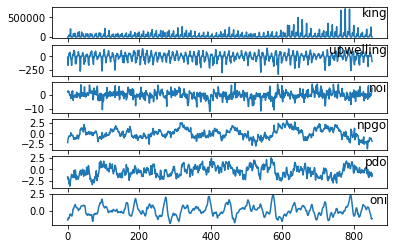

In [28]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [29]:
# convert series to supervised learning
# series_to_supervised from Jason Brownlee's "Multivariate Time Series Forecasting in Keras"
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 6
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000006   0.520913   0.710488   0.220877   0.329032   0.119048   
7    0.000006   0.079848   0.683284   0.332829   0.238710   0.166667   
8    0.000035   0.399240   0.731936   0.405446   0.283871   0.190476   
9    0.009241   0.566540   0.675895   0.422088   0.267742   0.166667   
10   0.070540   0.764259   0.689713   0.456883   0.074194   0.190476   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  ...  var3(t-1)  var4(t-1)  \
6    0.000006   0.079848   0.683284   0.332829  ...   0.632281   0.464448   
7    0.000035   0.399240   0.731936   0.405446  ...   0.567508   0.440242   
8    0.009241   0.566540   0.675895   0.422088  ...   0.572306   0.468986   
9    0.070540   0.764259   0.689713   0.456883  ...   0.591786   0.461422   
10   0.023221   0.703422   0.632281   0.464448  ...   0.461760   0.570348   

    var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
6    0.182258   0.238095  

In [30]:
# split into train and test sets
values = reframed.values
n_train_months = 66 * 12 # MENTAL NOTE: IF ERROR IN MOTH TO YEAR CHECK THIS
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(792, 6, 6) (792,) (54, 6, 6) (54,)


In [31]:
X_train, X_dev, y_train, y_dev = train_test_split(train_X, train_y, test_size=0.10, shuffle=False)

In [32]:
print(X_dev.shape)
print(y_dev.shape)
print(X_train.shape)
print(y_train.shape)
print(test_X.shape)
print(test_y.shape)

(80, 6, 6)
(80,)
(712, 6, 6)
(712,)
(54, 6, 6)
(54,)


Epoch 1/1000
1/1 - 6s - loss: 0.0123 - root_mean_squared_error: 0.1107 - val_loss: 0.0491 - val_root_mean_squared_error: 0.2215
Epoch 2/1000
1/1 - 0s - loss: 0.0116 - root_mean_squared_error: 0.1076 - val_loss: 0.0478 - val_root_mean_squared_error: 0.2187
Epoch 3/1000
1/1 - 0s - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0467 - val_root_mean_squared_error: 0.2162
Epoch 4/1000
1/1 - 0s - loss: 0.0105 - root_mean_squared_error: 0.1027 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2138
Epoch 5/1000
1/1 - 0s - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0448 - val_root_mean_squared_error: 0.2116
Epoch 6/1000
1/1 - 0s - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.0440 - val_root_mean_squared_error: 0.2097
Epoch 7/1000
1/1 - 0s - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2079
Epoch 8/1000
1/1 - 0s - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0426 - val_root_mea

Epoch 40/1000
1/1 - 0s - loss: 0.0093 - root_mean_squared_error: 0.0962 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2050
Epoch 41/1000
1/1 - 0s - loss: 0.0093 - root_mean_squared_error: 0.0962 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2048
Epoch 42/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0962 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2046
Epoch 43/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0961 - val_loss: 0.0418 - val_root_mean_squared_error: 0.2044
Epoch 44/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0961 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2043
Epoch 45/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0961 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2041
Epoch 46/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0961 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2040
Epoch 47/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0961 - val_loss: 0.0416 - val_

Epoch 79/1000
1/1 - 0s - loss: 0.0091 - root_mean_squared_error: 0.0953 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2040
Epoch 80/1000
1/1 - 0s - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2040
Epoch 81/1000
1/1 - 0s - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2040
Epoch 82/1000
1/1 - 0s - loss: 0.0090 - root_mean_squared_error: 0.0951 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2040
Epoch 83/1000
1/1 - 0s - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.0415 - val_root_mean_squared_error: 0.2038
Epoch 84/1000
1/1 - 0s - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0415 - val_root_mean_squared_error: 0.2036
Epoch 85/1000
1/1 - 0s - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2034
Epoch 86/1000
1/1 - 0s - loss: 0.0090 - root_mean_squared_error: 0.0947 - val_loss: 0.0413 - val_

Epoch 118/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1930
Epoch 119/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945
Epoch 120/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1925
Epoch 121/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0889 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1926
Epoch 122/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1934
Epoch 123/1000
1/1 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1919
Epoch 124/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0886 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1920
Epoch 125/1000
1/1 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.037

Epoch 157/1000
1/1 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1868
Epoch 158/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1864
Epoch 159/1000
1/1 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1859
Epoch 160/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0834 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1855
Epoch 161/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1851
Epoch 162/1000
1/1 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1847
Epoch 163/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1843
Epoch 164/1000
1/1 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.033

Epoch 196/1000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1727
Epoch 197/1000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1726
Epoch 198/1000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1721
Epoch 199/1000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1721
Epoch 200/1000
1/1 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0294 - val_root_mean_squared_error: 0.1715
Epoch 201/1000
1/1 - 0s - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0294 - val_root_mean_squared_error: 0.1715
Epoch 202/1000
1/1 - 0s - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1710
Epoch 203/1000
1/1 - 0s - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.029

Epoch 235/1000
1/1 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1606
Epoch 236/1000
1/1 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1606
Epoch 237/1000
1/1 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1607
Epoch 238/1000
1/1 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1600
Epoch 239/1000
1/1 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1596
Epoch 240/1000
1/1 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1597
Epoch 241/1000
1/1 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1594
Epoch 242/1000
1/1 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.025

Epoch 274/1000
1/1 - 0s - loss: 0.0046 - root_mean_squared_error: 0.0676 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1513
Epoch 275/1000
1/1 - 0s - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1489
Epoch 276/1000
1/1 - 0s - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1493
Epoch 277/1000
1/1 - 0s - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1512
Epoch 278/1000
1/1 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0667 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1495
Epoch 279/1000
1/1 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0665 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1475
Epoch 280/1000
1/1 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1493
Epoch 281/1000
1/1 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.022

Epoch 313/1000
1/1 - 0s - loss: 0.0041 - root_mean_squared_error: 0.0637 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1441
Epoch 314/1000
1/1 - 0s - loss: 0.0040 - root_mean_squared_error: 0.0636 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1448
Epoch 315/1000
1/1 - 0s - loss: 0.0040 - root_mean_squared_error: 0.0636 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1431
Epoch 316/1000
1/1 - 0s - loss: 0.0040 - root_mean_squared_error: 0.0636 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1444
Epoch 317/1000
1/1 - 0s - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1436
Epoch 318/1000
1/1 - 0s - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1430
Epoch 319/1000
1/1 - 0s - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1443
Epoch 320/1000
1/1 - 0s - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.020

Epoch 352/1000
1/1 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1385
Epoch 353/1000
1/1 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1419
Epoch 354/1000
1/1 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1384
Epoch 355/1000
1/1 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0619 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1406
Epoch 356/1000
1/1 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1391
Epoch 357/1000
1/1 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0617 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1391
Epoch 358/1000
1/1 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1400
Epoch 359/1000
1/1 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.019

Epoch 391/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1362
Epoch 392/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1351
Epoch 393/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1365
Epoch 394/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1345
Epoch 395/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1370
Epoch 396/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1338
Epoch 397/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1376
Epoch 398/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.017

Epoch 430/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0581 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1308
Epoch 431/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1316
Epoch 432/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1297
Epoch 433/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0579 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1323
Epoch 434/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0579 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1285
Epoch 435/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1343
Epoch 436/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0585 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1283
Epoch 437/1000
1/1 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.017

Epoch 469/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1272
Epoch 470/1000
1/1 - 0s - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1252
Epoch 471/1000
1/1 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1250
Epoch 472/1000
1/1 - 0s - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1323
Epoch 473/1000
1/1 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1260
Epoch 474/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 475/1000
1/1 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1308
Epoch 476/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0579 - val_loss: 0.015

Epoch 508/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 509/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1184
Epoch 510/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 511/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0539 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 512/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1184
Epoch 513/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1186
Epoch 514/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0537 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 515/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.014

Epoch 547/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0519 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 548/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 549/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 550/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 551/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 552/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 553/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1119
Epoch 554/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.013

Epoch 586/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 587/1000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0560 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1252
Epoch 588/1000
1/1 - 0s - loss: 0.0032 - root_mean_squared_error: 0.0566 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 589/1000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 590/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0537 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1084
Epoch 591/1000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1155
Epoch 592/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0537 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1070
Epoch 593/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0543 - val_loss: 0.011

Epoch 625/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0499 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1030
Epoch 626/1000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1061
Epoch 627/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 628/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0505 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1010
Epoch 629/1000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029
Epoch 630/1000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1037
Epoch 631/1000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1015
Epoch 632/1000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.010

Epoch 664/1000
1/1 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0551 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 665/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 666/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 667/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 668/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999
Epoch 669/1000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1008
Epoch 670/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 671/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.011

Epoch 703/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 704/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933
Epoch 705/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 706/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0931
Epoch 707/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 708/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 709/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 710/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.008

Epoch 742/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0881
Epoch 743/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0881
Epoch 744/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 745/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878
Epoch 746/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0877
Epoch 747/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876
Epoch 748/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0875
Epoch 749/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.007

Epoch 781/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844
Epoch 782/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844
Epoch 783/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843
Epoch 784/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0842
Epoch 785/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0841
Epoch 786/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840
Epoch 787/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840
Epoch 788/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.007

Epoch 820/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0834
Epoch 821/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819
Epoch 822/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0830
Epoch 823/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0831
Epoch 824/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818
Epoch 825/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 826/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821
Epoch 827/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.006

Epoch 859/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 860/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800
Epoch 861/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801
Epoch 862/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0797
Epoch 863/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 864/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799
Epoch 865/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0796
Epoch 866/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.006

Epoch 898/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788
Epoch 899/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0786
Epoch 900/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 901/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799
Epoch 902/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 903/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0782
Epoch 904/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0786
Epoch 905/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.006

Epoch 937/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0773
Epoch 938/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0782
Epoch 939/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804
Epoch 940/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0774
Epoch 941/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0430 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778
Epoch 942/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807
Epoch 943/1000
1/1 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0776
Epoch 944/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.006

Epoch 976/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0765
Epoch 977/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0769
Epoch 978/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0765
Epoch 979/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0765
Epoch 980/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0768
Epoch 981/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 982/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0763
Epoch 983/1000
1/1 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.005

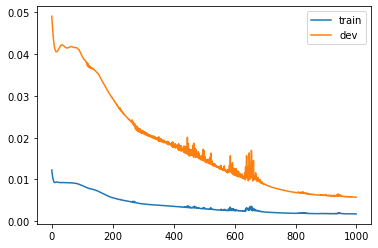

In [33]:
# design network
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(GRU(1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit network
#  
history = model.fit(train_X, train_y, epochs=1000, batch_size=1000, validation_data=(X_dev, y_dev), verbose=2, shuffle=False, callbacks=[model_checkpoint_callback])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [34]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))

In [35]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [36]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [37]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
def month_to_year(month_preds):
    month_preds = month_preds[6:]
    year_preds = []
    for i in range(12, len(month_preds) + 1, 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The test root mean squared error is {}.".format(rmse))

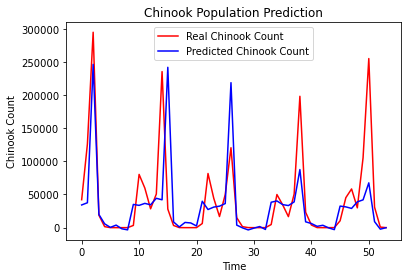

The test root mean squared error is 55628.85927286304.


In [38]:
plot_predictions(inv_y, inv_yhat)
return_rmse(inv_y, inv_yhat)

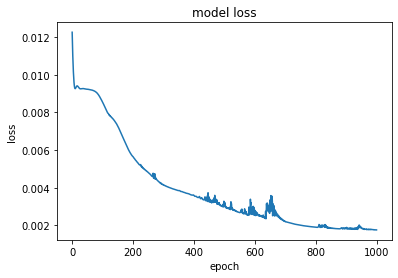

In [39]:
plot_loss(history)

In [40]:
preds = month_to_year(inv_yhat).astype(np.int64)
actual = month_to_year(inv_y).astype(np.int64)
print(preds)
print(actual)

    Count
0  476071
1  402949
2  288278
3  248099
    Count
0  488981
1  336030
2  381773
3  535746


In [41]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)

    Count
0  498710
1  439060
2  294840
3  347600


In [42]:
return_rmse(actual, traditional)

The test root mean squared error is 115829.72216361394.


In [43]:
return_rmse(actual, preds)

The test root mean squared error is 155021.71807121093.
